<a href="https://colab.research.google.com/github/pulakeshpradhan/Concepts-of-Programming/blob/main/IMD_Export_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee
import geemap
ee.Authenticate()
ee.Initialize(project='pulakeshpradhan')

## **Individual Collection**

In [ ]:
# Select a location (from previous code)
geometry = ee.Geometry.Point([85.8949998359892, 20.462094851812726])

# Generate years list
years = list(range(2021, 2023))

# Function to process collections (generalized for rain, tmax, and tmin)
def process_collection(variable, years):
    def process_year(year):
        # Load the image for the year
        y = ee.Image(f"projects/pulakeshpradhan/assets/IMD/{variable.upper()}/{variable.capitalize()}_{year}")

        # Get band names
        band_names = y.bandNames()

        # Set start date for the year
        start_date = ee.Date(f'{year}-01-01')

        # Function to process each band
        def process_band(name):
            band_image = y.select([name])
            index = ee.Number.parse(ee.String(name).slice(1)).subtract(1)
            date = start_date.advance(index, 'day')
            return band_image.set('system:time_start', date.millis())

        # Map over band names
        images = band_names.map(process_band)

        # Create collection from images
        collection = ee.ImageCollection.fromImages(images)

        # Rename bands
        return collection.map(lambda image: image.rename(variable.lower()))

    # Create and merge collections for all years
    collections = [process_year(year) for year in years]
    merged_collection = collections[0]
    for collection in collections[1:]:
        merged_collection = merged_collection.merge(collection)

    return merged_collection

# Process all three collections
merged_rain_collection = process_collection('RAIN', years)
merged_tmax_collection = process_collection('TMAX', years)
merged_tmin_collection = process_collection('TMIN', years)

print('Collections created successfully')

Collections created successfully


## **Monthly Collection**

In [ ]:
def create_monthly_collections():
    # Define the full range of years
    years = list(range(2021, 2023))  # 1951 to 2023

    all_monthly_collections = []

    for year in years:
        months = ee.List.sequence(1, 12)

        def aggregate_month(month):
            # Total monthly rainfall
            monthly_rain = merged_rain_collection \
                .filter(ee.Filter.calendarRange(year, year, 'year')) \
                .filter(ee.Filter.calendarRange(month, month, 'month'))
            total_rain = monthly_rain.sum().rename('Rain')

            # Average Tmax for the month
            monthly_tmax = merged_tmax_collection \
                .filter(ee.Filter.calendarRange(year, year, 'year')) \
                .filter(ee.Filter.calendarRange(month, month, 'month'))
            average_tmax = monthly_tmax.mean().rename('Tmax')

            # Average Tmin for the month
            monthly_tmin = merged_tmin_collection \
                .filter(ee.Filter.calendarRange(year, year, 'year')) \
                .filter(ee.Filter.calendarRange(month, month, 'month'))
            average_tmin = monthly_tmin.mean().rename('Tmin')

            # Combine all bands
            image = total_rain.addBands(average_tmax).addBands(average_tmin).set({
                'system:time_start': ee.Date.fromYMD(year, month, 1).millis(),
                'year': year,
                'month': month
            })

            return image

        # Map over months for each year
        monthly_images = months.map(aggregate_month)
        year_collection = ee.ImageCollection.fromImages(monthly_images)
        all_monthly_collections.append(year_collection)

    # Merge all years into one collection
    merged_monthly_collection = all_monthly_collections[0]
    for collection in all_monthly_collections[1:]:
        merged_monthly_collection = merged_monthly_collection.merge(collection)

    return merged_monthly_collection

# Create monthly collections for all years
monthly_collection = create_monthly_collections()
print('Monthly Collections created successfully for 1951-2023')


Monthly Collections created successfully for 1951-2023


In [ ]:
# monthly_collection

## **Daily Collection**

In [ ]:
def create_daily_collections():
    # Define the full range of years
    years = list(range(2021, 2023))  # 2021 to 2022

    all_daily_collections = []

    for year in years:
        # Get all days in the year
        start_date = ee.Date.fromYMD(year, 1, 1)
        end_date = ee.Date.fromYMD(year, 12, 31)
        days = ee.List.sequence(0, end_date.difference(start_date, 'day'))

        def aggregate_day(day_offset):
            current_date = start_date.advance(day_offset, 'day')

            # Daily rainfall
            daily_rain = merged_rain_collection \
                .filter(ee.Filter.date(current_date, current_date.advance(1, 'day')))
            total_rain = daily_rain.sum().rename('Rain')

            # Daily Tmax
            daily_tmax = merged_tmax_collection \
                .filter(ee.Filter.date(current_date, current_date.advance(1, 'day')))
            daily_tmax_value = daily_tmax.mean().rename('Tmax')

            # Daily Tmin
            daily_tmin = merged_tmin_collection \
                .filter(ee.Filter.date(current_date, current_date.advance(1, 'day')))
            daily_tmin_value = daily_tmin.mean().rename('Tmin')

            # Get date components for metadata
            year = current_date.get('year')
            month = current_date.get('month')
            day = current_date.get('day')

            # Combine all bands
            image = total_rain.addBands(daily_tmax_value).addBands(daily_tmin_value).set({
                'system:time_start': current_date.millis(),
                'year': year,
                'month': month,
                'day': day
            })

            return image

        # Map over days for each year
        daily_images = days.map(aggregate_day)
        year_collection = ee.ImageCollection.fromImages(daily_images)
        all_daily_collections.append(year_collection)

    # Merge all years into one collection
    merged_daily_collection = all_daily_collections[0]
    for collection in all_daily_collections[1:]:
        merged_daily_collection = merged_daily_collection.merge(collection)

    return merged_daily_collection

# Create daily collections for all years
daily_collection = create_daily_collections()
print('Daily Collections created successfully for 2021-2022')

Daily Collections created successfully for 2021-2022


In [ ]:
daily_collection

## New Section

In [ ]:
import pandas as pd

In [ ]:
# Study Area
# geometry = ee.Geometry.Point([85.8949998359892, 20.462094851812726])
geometry = ee.FeatureCollection('projects/pulakeshpradhan/assets/shp/jhansi')

In [ ]:
# Collection
collection = daily_collection
# collection = monthly_collection

In [ ]:
# Get the list of dates from the ImageCollection
dates = collection.aggregate_array('system:time_start').getInfo()

# Create DataFrame with dates (df_dates)
df_dates = pd.DataFrame({'system:time_start': dates})
df_dates['Date'] = pd.to_datetime(df_dates['system:time_start'], unit='ms')
df_dates['Date'] = df_dates['Date'].dt.date
df_dates = df_dates.drop('system:time_start', axis=1)
df_dates = df_dates.sort_values('Date')
df_dates = df_dates.reset_index(drop=True)
df_dates

,Date
0,2021-01-01
1,2021-01-02
2,2021-01-03
3,2021-01-04
4,2021-01-05
...,...
725,2022-12-27
726,2022-12-28
727,2022-12-29
728,2022-12-30


In [ ]:
%%time
# Define function to reduce image by regions
def reduce_image(image):
    return image.reduceRegions(
        collection=geometry,
        reducer=ee.Reducer.mean(),
        scale=5000
    ).select(['Rain', 'Tmax', 'Tmin', 'system:time_start'])


# Map the reduction function and get indices data
reduced = collection.map(reduce_image).flatten()
data = reduced.getInfo()
features = data['features']
df_indices = pd.DataFrame([f['properties'] for f in features])
df_indices

CPU times: user 2.68 s, sys: 424 ms, total: 3.11 s
Wall time: 42.3 s


,Rain,Tmax,Tmin
0,0.00000,21.734985,4.814890
1,0.00000,23.880947,8.384197
2,0.00000,25.358402,11.812585
3,0.00000,24.232386,13.573006
4,0.61619,25.778633,13.522591
...,...,...,...
725,0.00000,21.890955,5.933203
726,0.00000,24.436401,5.058146
727,0.00000,25.669912,6.287925
728,0.00000,27.054283,9.170710


In [ ]:
# Create final combined DataFrame (df)
df = pd.DataFrame({
    'Date': df_dates['Date']
}).join(df_indices)

# Sort and clean the final DataFrame
df = df.sort_values('Date')
df = df.reset_index(drop=True)

# Convert system:time_start to datetime if it exists in df_indices
if 'system:time_start' in df.columns:
    df = df.drop('system:time_start', axis=1)

# Display information about final DataFrame
print("First few rows of the final DataFrame:")
print(df.head())

print("\nDataFrame Info:")
print(df.info())

print("\nBasic Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

First few rows of the final DataFrame:
         Date     Rain       Tmax       Tmin
0  2021-01-01  0.00000  21.734985   4.814890
1  2021-01-02  0.00000  23.880947   8.384197
2  2021-01-03  0.00000  25.358402  11.812585
3  2021-01-04  0.00000  24.232386  13.573006
4  2021-01-05  0.61619  25.778633  13.522591

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    730 non-null    object 
 1   Rain    730 non-null    float64
 2   Tmax    730 non-null    float64
 3   Tmin    730 non-null    float64
dtypes: float64(3), object(1)
memory usage: 22.9+ KB
None

Basic Statistics:
             Rain        Tmax        Tmin
count  730.000000  730.000000  730.000000
mean     3.113619   32.823332   18.753341
std     12.170210    6.459433    7.250228
min      0.000000   14.928738    3.184422
25%      0.000000   28.748740   11.935722
50%      0.000000  

## ARIMA Model

In [ ]:
df = df[['Date', 'Rain']].rename(columns={'Rain': 'value'})

In [ ]:
# df

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -8.183549
p-value: 0.000000


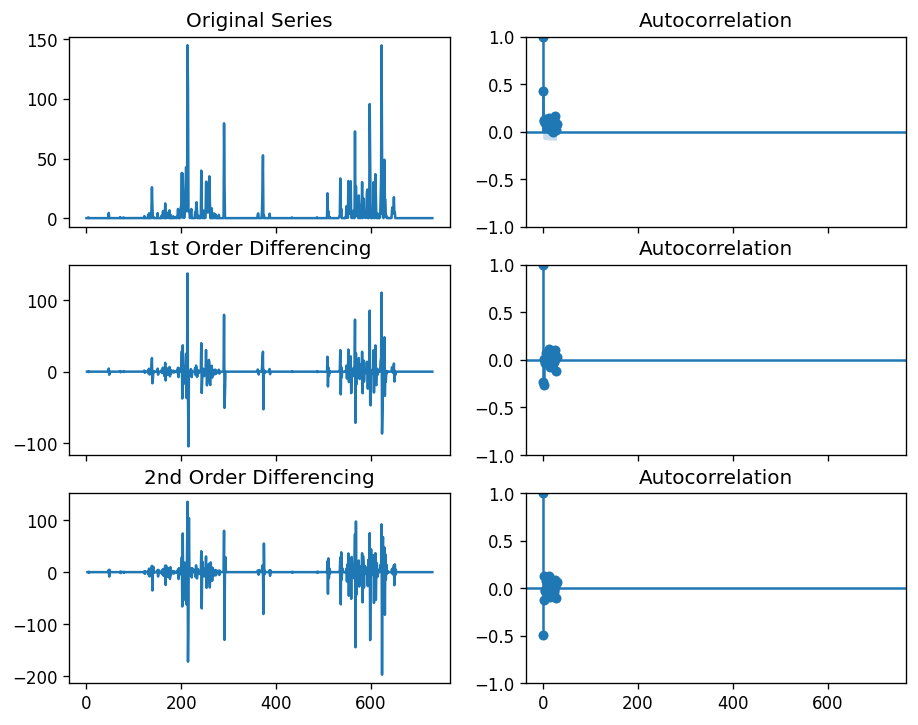

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

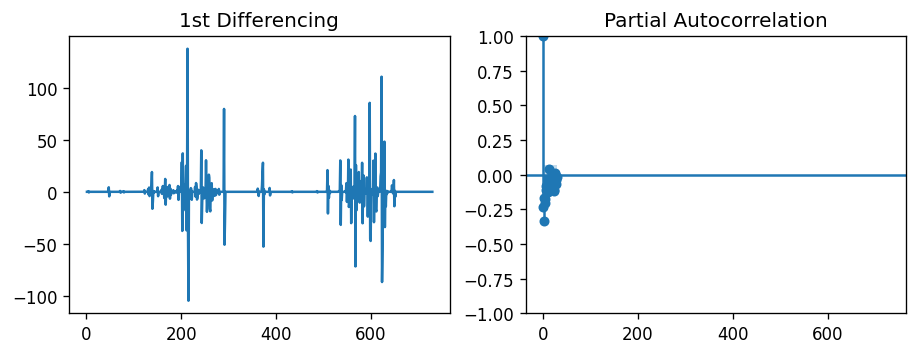

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

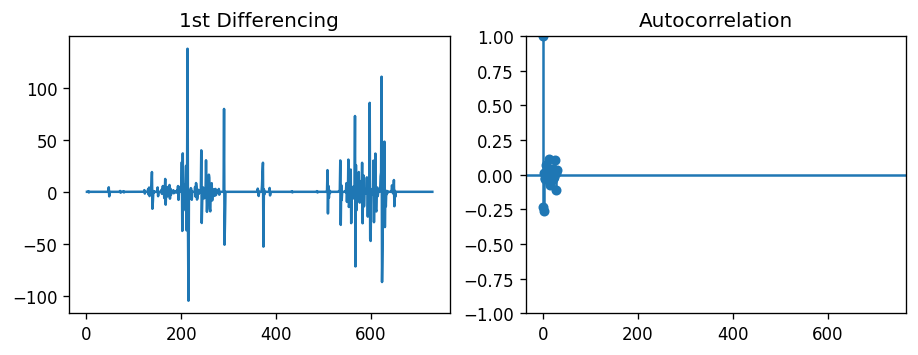

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
"https://www.kaggle.com/code/prashant111/arima-model-for-time-series-forecasting"

'https://www.kaggle.com/code/prashant111/arima-model-for-time-series-forecasting'

# New Section

In [ ]:
def calculate_zonal_statistics(monthly_col, region_path, start_year, end_year):
    """
    Calculate zonal statistics for a region using Earth Engine collections

    Args:
        monthly_col: Earth Engine ImageCollection with monthly data
        region_path: Path to the region FeatureCollection in Earth Engine
        start_year: Start year for analysis
        end_year: End year for analysis
    """
    # Load the region of interest
    region = ee.FeatureCollection(region_path)

    def process_image(image):
        # Calculate zonal statistics for each image
        stats = image.reduceRegions(
            collection=region,
            reducer=ee.Reducer.mean(),
            scale=1000
        )

        def add_properties(feature):
            # Add image properties to each feature
            return feature.set({
                'year': image.get('year'),
                'month': image.get('month'),
                'Rain': feature.get('Rain'),
                'Tmax': feature.get('Tmax'),
                'Tmin': feature.get('Tmin'),
                'DISTRICT': feature.get('DISTRICT')
            })

        # Map over features to add properties
        return stats.map(add_properties)
  # Map over the image collection and flatten results
    zonal_stats = monthly_col.map(process_image).flatten()

    # Select required properties
    properties = ['DISTRICT', 'year', 'month', 'Rain', 'Tmax', 'Tmin']
    selected_stats = zonal_stats.select(properties)

    # Print results to console
    print('Selected Zonal Statistics:', selected_stats.getInfo())

    # Export to Google Drive
    export_task = ee.batch.Export.table.toDrive(
        collection=selected_stats,
        description=f'TimeSeries_{start_year}_{end_year}',
        folder='GEE',
        fileFormat='CSV',
        selectors=properties
    )

    # Start the export task
    export_task.start()

    return selected_stats, export_task

In [ ]:


# Example usage:
if __name__ == "__main__":
    # Initialize Earth Engine
    ee.Initialize()

    # Define your inputs
    region_path = 'projects/pulakeshpradhan/assets/shp/Wb_District_new'
    start_year = 2021  # Replace with your start year
    end_year = 2022    # Replace with your end year

    # Assuming monthly_col is your prepared monthly collection
    # monthly_col = your_monthly_collection_preparation_function()

    # Calculate and export zonal statistics
    stats, task = calculate_zonal_statistics(
        monthly_col=monthly_collection,  # Use your monthly collection
        region_path=region_path,
        start_year=start_year,
        end_year=end_year
    )

    print(f"Export task started: {task.status()}")

Selected Zonal Statistics: Buffered data was truncated after reaching the output size limit.